## Objetivo *Geral*

Desenvolver um algoritmo capaz de prever o custo do seguro de saúde com o uso de _machine-learning_.

<p align=center>
<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjaINJHoujk9CWB8rox7nu-BbY6AHkqF8ULOnbqvZANGJVJH2vBJ4iQWz0MkvW4yIJbxiU5Tq6z8Kpu_nD9wAYjgN_Y5BLsallejRAj_4Xd7HQRWYmQtzNmnUVktygewSxGkcFo7ruAvgJX6NbP2M8NGALS8V8dsch7JlVlcY8kVqBYKyneeveicEpgcIA/s16000/data.png" width="60%"></p>
<br/>

In [1]:
pip install pycaret 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install ydata_profiling

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
from ydata_profiling import ProfileReport                 # manipulação de dados
import numpy as np
from sklearn.model_selection import train_test_split  # Scikit separar treino/teste
import pycaret                                        # Pycaret
from pycaret.regression import *                      # Pycaret para Regressão              # Para executar gráficos no Colab


In [5]:
dataset = pd.read_csv("insurance-formatado.csv")

In [6]:
dataset.describe()

,idade,imc,filhos,cobranca
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   sexo      1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   regiao    1338 non-null   object 
 6   cobranca  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Podemos observar que se trata de uma base de dados com 7 colunas e um total de 1338 linhas, contendo informações sobre cada assegurado.

# Análise Exploratória dos Dados

Essa é uma etapa essencial em projetos de ciência de dados onde se busca compreender melhor os dados seja por identificar padrões, outliers, possíveis relações entre as variáveis, etc. Nesse estudo, se exploraram informações que fossem relevantes para orientar as respostas dos objetivos indicados anteriormente (ver Objetivo Geral e Objetivos Específicos).


Para isso vou gerar um relatório que resume os dados, com o uso da biblioteca ProfileReport. A partir dele, se houver necessidade, será feito uma análise mais profunda. Contudo, ele já nos fornecerá informações suficientes para identificar anomalias como outliers e desbalanceamento nos dados.

A biblioteca Pandas Profiling oferece a função ProfileReport que cria automaticamente um relatório completo de análise exploratória de dados.
<br/>

Por isso, o uso do _ProfileReport_ agiliza a rotina da análise exploratória dos dados, contudo, não exime o cientista de dados de realizar o estudo aprofundado do relatório para compreender e interpretar os dados, além de identificar eventuais problemas que necessitam de tratamento.

## Gerar relatório

In [8]:
# report = ProfileReport(dataset)

In [9]:
# type_schema = {"Survived": "categorical", "Embarked": "categorical"}

report = dataset.profile_report(
    title="Titanic Boby",
      sort="ascending",
     
  )

report.config.variables.descriptions = {
      "Filhos": "Files in the filesystem",
      "teste": "Creation date",
      "datem": "Modification date",

  }



In [10]:
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

No relatório gerado acima percebe-se que:
- o conjunto é formado por 1338 registros e 7 atributos
- pelas primeiras e últimas entradas do dataset ele parece estar bem preenchido e sem anormalidades
- não há dados ausentes
- existe uma linha duplicada
- a idade tem uma alta correlação com o preço cobrado pelo seguro, o que faz bastante sentido
- bem como, é apontada a alta correlação entre a pessoa ser fumante, acabar pagando mais caro no seguro
<br/>
<br/>

Foi observado que as variáveis `age` e `children` estão em formato *float* o que não haveria necessidade e poderiam ser convertidos em tipo inteiro para economizar memória computacional, contudo, como é um conjunto relativamente pequeno, essa alteração não terá tantos efeitos.

As variáveis `age` e `smoker` estão desbalanceadas, uma vez que, na primeira há um pico maior na faixa dos 20 anos, enquanto que na segunda, há uma quantidade maior de pessoas não-fumantes do que de pessoas que fumam.

Já as variáveis `sex`, `region`, `children` e `bmi` estão bem balanceadas, sendo que em `bmi` identifica-se, inclusive, uma distribuição normal.

Dessa forma, o único tratamento necessário será a identificação e exclusão dos registros duplicado.

# Tratamento de Dados

Nessa sessão, irei prosseguir com 2 etapas de tratamento de dados:
* tratar dados duplicados
* preparar dados para _machine learning_

In [11]:
# identificar e visualizar registros duplicados
duplicatas = dataset.duplicated()
print(dataset[duplicatas])

     idade       sexo    imc  filhos fumante regiao   cobranca
581     19  masculino  30.59       0      no    sul  1639.5631


Pode-se reparar que a linha mostrada acima, está de acordo com o que foi mostrado no documento. Vamos prosseguir com a exclusão desse registro.

In [12]:
# remover linhas duplicadas
dataset_clean = dataset.drop_duplicates()

Por fim, a etapa essencial em qualquer projeto de machine learning envolver a preparação dos dados com a separação dos mesmos em 2 conjuntos distintos: um conjunto de treino e outro de testes para que o de treino seja utilizado no treinamento do algoritmo e o de testes seja usado apenas ao final desse estudo, como forma de compreender os acertos e erros do modelo criado.

Será feito na proporção de 90% para treino e 10% para testes. Bem como, vou aproveitar para resetar o index dos conjuntos para que não haja nenhuma possibilidade de identificação e relação entre os dados e, visualizar o tamanho que ficaram os conjuntos.

In [13]:
# separar os dados em teste e treino
## criar variável 'test' com 10% do data frame original
## com seed para gerar resultados reproduzíveis
## resetar index
test = dataset_clean.sample(frac=0.10, random_state=82).reset_index(drop=True)

## criar variável 'train' com tudo o que não estiver em 'test'
## resetar index
train = dataset_clean.drop(test.index).reset_index(drop=True)

# checar tamanho dos conjuntos
print(train.shape)
print(test.shape)

(1203, 7)
(134, 7)


In [14]:
train_new, test_new = train_test_split(dataset, test_size=0.2,random_state=42)

# Criação dos modelos de _Machine Learning_

A construção de um projeto completo de regressão com a utilização da biblioteca _PyCaret_ 

_PyCaret_ é uma biblioteca de uso simplificado que auxiliam o processo de construção de modelos de _machine-learning_ por meio de funções automatizadas de etapas comuns ao desenvolvimento desses modelos. Isso faz dela uma ferramenta extremamente útil para rapidamente construir modelos de aprendizado de máquina.

A primeira etapa consiste em passar os parâmetros necessários para configurar os dados do nosso problema de regressão.

Para isso, informamos qual é o conjunto de dados que deverá ser utilizado, ou seja, `dataset_clean`; precisamos apontar qual é o atributo alvo, isto é, aquele que queremos que seja previsto pelo algoritmo; também passei uma divisão de 75% para o conjunto de treino, o que faz com que o conjunto de testes fique com os 25% restantes; coloquei `True` para o parâmetro `normalize` para que os dados sejam normalizados (pelo padrão da biblioteca que usa o _ZScore_); e, por fim, passei um valor inteiro para que os resultados possam ser reproduzidos novamente em qualquer ambiente.

In [15]:
# 1. configurar regressão
reg = setup(data=train,       # conjunto de dados
            target='cobranca', # classe alvo
            train_size=0.75,  # definir tamanho da divisão dos conjuntos
            normalize=True,   # normalizar os dados em uma única escala (zscore)
            session_id=38)    # seed para gerar resultados reproduzíveis

,Description,Value
0,Session id,38
1,Target,cobranca
2,Target type,Regression
3,Original data shape,"(1203, 7)"
4,Transformed data shape,"(1203, 11)"
5,Transformed train set shape,"(902, 11)"
6,Transformed test set shape,"(301, 11)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


## 2. Criação e comparação de modelos

Aqui, serão criados e treinados todos os modelos disponíveis na biblioteca do _PyCaret_, e então, avaliados com validação cruzada estratificada (por padrão 10 dobras). Ademais, os resultados, por padrão, são ranqueados de acordo com o valor obtido com a métrica do Coeficiente de Determinação - R2 (mas isso poderia ser alterado se houvesse necessidade). Vou manter essa configuração, pois essa será a métrica utilizada também na próxima etapa.

In [16]:
# 2. criar e comparar modelos
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2467.1522,21095348.9370,4453.8364,0.8412,0.3983,0.2712,0.0210
lightgbm,Light Gradient Boosting Machine,2727.4747,21708902.3976,4545.5437,0.8363,0.5103,0.3318,0.0550
rf,Random Forest Regressor,2703.8718,23113355.8527,4687.8127,0.8253,0.4465,0.3275,0.0450
ada,AdaBoost Regressor,3617.3791,23969486.6523,4825.5099,0.8204,0.5406,0.5551,0.0130
et,Extra Trees Regressor,2772.4515,26549968.8877,5057.8964,0.8011,0.4505,0.3126,0.0380
knn,K Neighbors Regressor,3558.2835,32180946.8000,5629.1287,0.7621,0.4690,0.3633,0.0130
lr,Linear Regression,4156.9545,36016444.3149,5960.2892,0.7349,0.5771,0.4153,0.3770
llar,Lasso Least Angle Regression,4167.1828,36048748.1931,5960.9651,0.7346,0.5598,0.4214,0.0110
br,Bayesian Ridge,4170.6907,36050975.9817,5961.7502,0.7346,0.5569,0.4222,0.0110
ridge,Ridge Regression,4168.4801,36048759.8273,5961.1566,0.7346,0.5583,0.4217,0.0130


Acima, foram criados e testados 19 modelos diferentes. Sendo que, os que apresentaram os melhores resultados foram o Gradient Boosting Regressor e o Passive Aggressive Regressor.

Podemos confirmar o melhor algoritmo criado com o código abaixo:

In [17]:
# imprimir o melhor modelo
print(best)

GradientBoostingRegressor(random_state=38)


Esse é um algoritmo de _machine-learning_, da família de métodos _Ensemble_ de Árvores de Decisão, que aprende com erros e, por isso, melhora a cada iteração. Ele é usado para regressões e, por conta disso, se adaptou muito bem ao nosso problema em questão.

Em essência, ele possui 3 elementos:

- _loss function_: para ser otimizada
- _weak learner_: para fazer previsões
- modelo aditivo para adicionar aos _weak learners_ para minimizar a _loss function_

In [18]:
# instanciar modelo
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2577.1716,24365483.7690,4936.1406,0.8564,0.4160,0.2875
1,2545.2464,22032870.8513,4693.9185,0.8284,0.3853,0.3011
2,1955.8585,10098051.4809,3177.7431,0.9349,0.3066,0.2349
3,2982.5252,35120470.3753,5926.2526,0.6478,0.5063,0.2811
4,2541.9641,19497667.9265,4415.6164,0.8646,0.3970,0.3120
5,3531.7119,37611830.8873,6132.8485,0.6932,0.4980,0.3038
6,2840.5129,22447658.7054,4737.8960,0.8708,0.4467,0.3052
7,2249.2646,23966002.3610,4895.5084,0.8317,0.4587,0.2399
8,1694.4067,8251921.7866,2872.6158,0.9412,0.3123,0.2337


In [19]:
# ajuste dos parâmetros
tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2909.3001,25528742.3300,5052.5976,0.8496,0.4648,0.3567
1,2661.9049,23635916.0596,4861.6783,0.8159,0.3972,0.2948
2,2094.0073,10383602.3787,3222.3598,0.9331,0.3204,0.2385
3,3144.8505,37044127.7027,6086.3887,0.6285,0.5267,0.3058
4,2507.7062,17926468.4676,4233.9660,0.8755,0.3717,0.2860
5,3162.2018,32611514.2482,5710.6492,0.7340,0.4591,0.2604
6,2552.5549,21147368.0263,4598.6268,0.8783,0.4446,0.2658
7,2656.5299,25443299.8246,5044.1352,0.8213,0.5032,0.3255
8,2049.3451,9552341.2850,3090.6862,0.9319,0.3789,0.3075


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


 **Com o ajuste de parâmetros não tivemos nenhuma melhora no resultado do R2: saímos de 0.8412 para 0.8391. Portando, ele volta ao estado original do melhor resultado.**

Nessa sessão vou gerar diferentes gráficos para visualizar e auxiliar a compreensão do modelo criado.

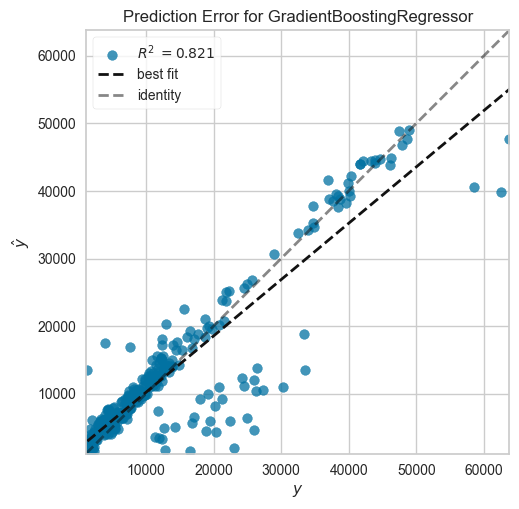

In [20]:
plot_model(tuned_gbr, plot='error')

Vamos checar também quais atributos são mais relevantes para o modelo gerado com o gráfico abaixo.

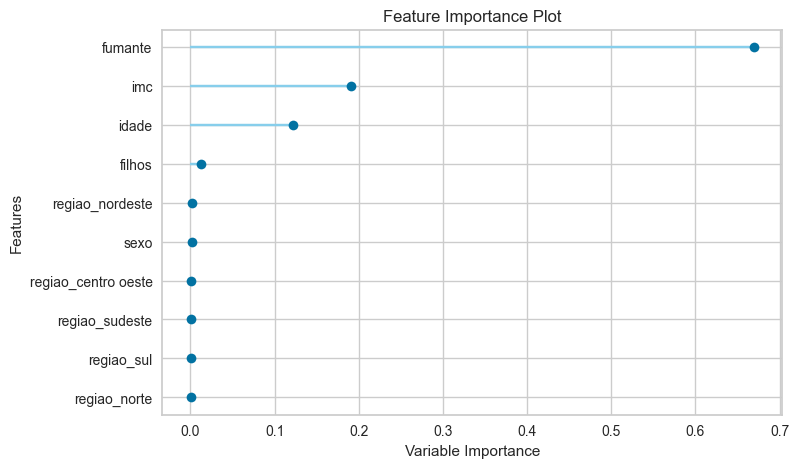

In [21]:
plot_model(tuned_gbr, plot='feature')

A seguir, no gráfico de Resíduos, pode-se avaliar os resíduos do modelo quanto à previsão do modelo. O resíduo é a diferença entre os valores reais e os valores previstos pelo modelo. Portanto, com esse gráfico consegue-se avaliar a qualidade do modelo que criamos.

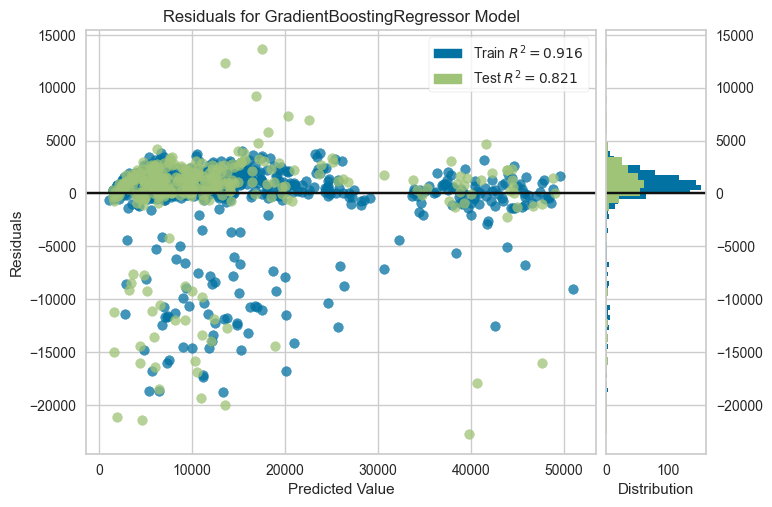

In [22]:
plot_model(tuned_gbr, plot='residuals')

Por fim, o gráfico de Curva de Aprendizado. Com ele podemos checar o desempenho do modelo à medida que o conjunto de treinamento aumenta. Ou seja, pode-se entender o comportamento do modelo com diferentes quantidades de dados, o que pode levar à reflexões quanto à necessidade de mais dados ou mesmo da complexidade do modelo.


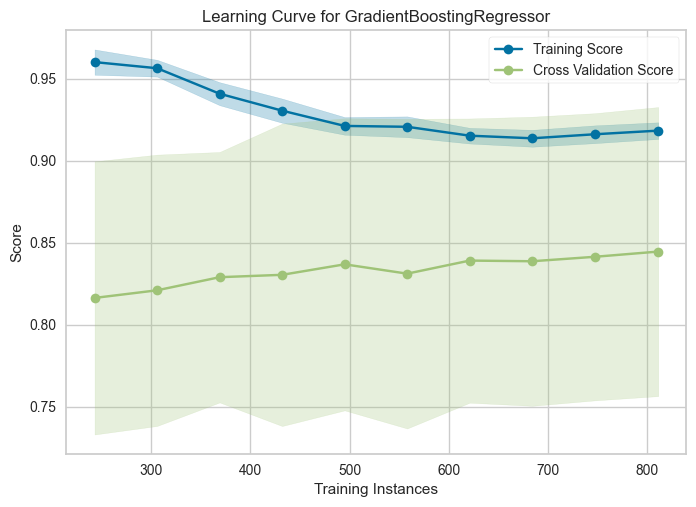

In [23]:
plot_model(tuned_gbr, plot='learning')

Podemos observar acima, que as linhas tendem a convergir para um valor razoavelmente estável, próximo de 0.91 e 0.84.

Vale imprimir ainda, um modelo interativo geral de avaliação, disponível com a função evaluate_model o qual fornece diversas informações sobre o modelo construído. Por exemplo: a estrutura do pipeline do modelo e os hiperparâmetros finais utilizados.

In [24]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## 5. Realizar previsões

Antes de finalizar o modelo, fazemos uma verificação no qual realizamos uma previsão, com o conjunto de testes separado pela função `setup` na primeira etapa de criação do modelo. Dessa forma, checamos se não há divergências nos resultados apresentados.

In [25]:
# fazer previsões
predict_model(tuned_gbr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2869.4492,27384833.7884,5233.0521,0.8206,0.4993,0.3233


Observe que o resultado de 0.8246 encontra-se dentro do desvio padrão previsto na etapa 2, de 0.0870.

## 6. Finalizar o modelo

Na última etapa do processo de criação do modelo, finalizamos ele com a função `finalize_model` que irá treinar o modelo com o conjunto completo que foi informado na função `setup`. Ou seja, ele irá incluir o conjunto que havia sido separado para os testes.

In [26]:
# finalizar modelo
final_gbr = finalize_model(tuned_gbr)

In [27]:
# verificar parâmetros
print(final_gbr)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['idade', 'imc', 'filhos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['sexo', 'fumante', 'regiao'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['sexo', 'fumante'],
                                    tran...
                                                                        {'col': 'fumante',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': no     0
yes    1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['regiao'],
                     

# Avaliação no conjunto de testes

Para concluir esse estudo, utilizamos o conjunto de testes separado na sessão de Tratamento de Dados para que possamos avaliar o modelo com dados que ele nunca teve contato anteriormente.

In [28]:
# previsão em dados não vistos
prediction = predict_model(final_gbr, data=test)
prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2206.1792,14298860.4316,3781.3834,0.9073,0.3357,0.2420


,idade,sexo,imc,filhos,fumante,regiao,cobranca,prediction_label
0,24,feminino,39.490002,0,no,sul,2480.979004,3680.154138
1,44,feminino,36.955002,1,no,centro oeste,8023.135254,9740.893609
2,58,feminino,31.825001,2,no,sul,13607.369141,14980.425831
3,19,feminino,24.700001,0,no,sul,1737.375977,2804.266876
4,24,masculino,29.830000,0,yes,sul,18648.421875,19787.975743


Observa-se que ele obteve um R2 maior do que o valor obtido nos testes, de 0.8430 para 0.9073 e, dentro do desvio padrão previsto de 0.0870.

Além disso, temos um novo atributo denominado `prediction_label` no qual podemos ver a previsão do modelo para o custo do seguro de vida.

# Conclusão Final

O estudo teve por objetivo central o desenvolvimento um algoritmo capaz de prever o custo do seguro de saúde com o uso de machine-learning.

Com o uso da biblioteca _Pandas Profiling_ foi possível obter em poucos segundos um panorama do conjunto de dados, com a geração de um relatório completo, que auxiliou na análise exploratória.

Após o devido tratamento dos dados, com a ajuda da biblioteca _PyCaret_, foram gerados 19 modelos de regressão, que foram avaliados por diversas métricas. Contudo, optou-se por ordenar os resultados pelo Coeficiente de Determinação - R2. Com isso, se chegou ao melhor modelo criado pelo algoritmo _Gradient Boosting Regressor_ com o R2 igual a 0.8430.
<br/>

Na sequência foi feito o ajuste de hiperparâmetros do modelo, ao qual não foi possível obter uma melhora do modelo. E, na etapa seguinte, de realizar testes com os dados do _PyCaret_ o modelo ficou dentro do esperado. Já nos testes finais, onde se utilizaram novos dados, o Coeficiente de Determinação apresentou uma melhora significativa, saltando para 0.9166 e dentro dos limites de desvio padrão previstos.